# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [9]:
from kan import *

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

In [10]:
# visualize dataset
dataset

{'train_input': tensor([[-0.0075,  0.5547],
         [ 0.5364,  0.1791],
         [-0.8230,  0.1526],
         ...,
         [-0.3216, -0.4567],
         [ 0.0036, -0.3966],
         [-0.1923, -0.8376]]),
 'test_input': tensor([[-0.0850, -0.2418],
         [-0.7799, -0.0967],
         [-0.0061, -0.4609],
         ...,
         [ 0.0392, -0.2945],
         [-0.3037, -0.0922],
         [ 0.7534,  0.8848]]),
 'train_label': tensor([[1.3287],
         [2.7886],
         [0.6038],
         [0.6248],
         [0.5784],
         [2.4956],
         [0.9510],
         [2.2221],
         [0.9604],
         [5.0185],
         [0.7090],
         [0.6934],
         [1.4567],
         [0.4631],
         [0.6223],
         [1.1396],
         [2.6025],
         [3.8784],
         [0.7173],
         [0.5919],
         [5.1320],
         [2.4276],
         [0.5478],
         [2.5004],
         [0.6470],
         [1.3875],
         [2.6785],
         [0.9634],
         [0.4302],
         [0.7583],
      

Train KAN (grid=3)

In [2]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 1.45e-02 | test loss: 1.51e-02 | reg: 2.97e+00 : 100%|██| 20/20 [00:04<00:00,  4.49it/s]


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

Train KAN (grid=10)

In [4]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 3.42e-04 | test loss: 3.50e-04 | reg: 2.96e+00 : 100%|██| 20/20 [00:03<00:00,  6.02it/s]


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [5]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 6.42e-03 | test loss: 6.51e-03 | reg: 2.75e+00 : 100%|██| 50/50 [00:08<00:00,  5.95it/s]
train loss: 9.12e-04 | test loss: 1.10e-03 | reg: 2.97e+00 : 100%|██| 50/50 [00:10<00:00,  4.72it/s]
train loss: 1.57e-04 | test loss: 3.85e-04 | reg: 2.97e+00 : 100%|██| 50/50 [00:08<00:00,  5.95it/s]
train loss: 1.62e-05 | test loss: 9.41e-05 | reg: 2.97e+00 : 100%|██| 50/50 [00:10<00:00,  4.64it/s]
train loss: 8.31e-06 | test loss: 9.16e-05 | reg: 2.97e+00 : 100%|██| 50/50 [00:06<00:00,  7.16it/s]


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

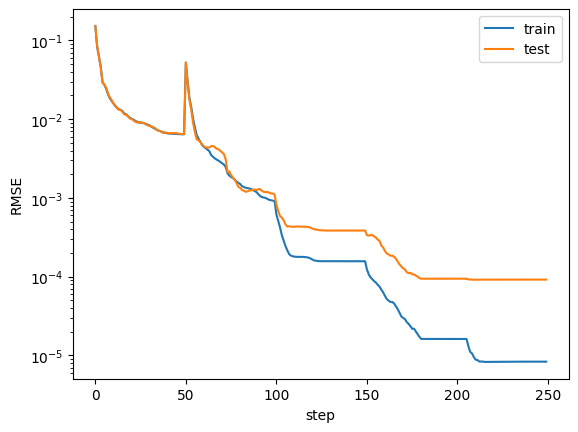

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

Text(0, 0.5, 'RMSE')

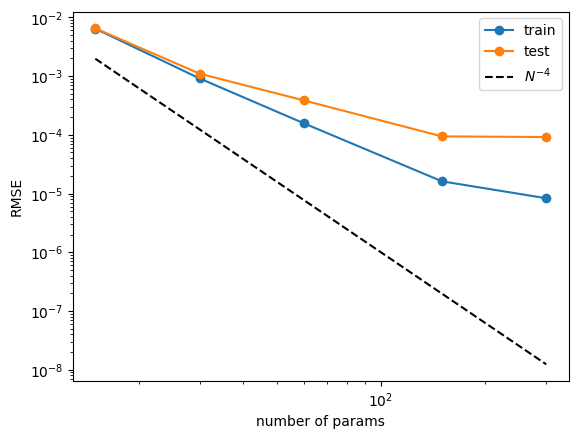

In [7]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')